<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f415fd8b7d0>]],
      dtype=object)

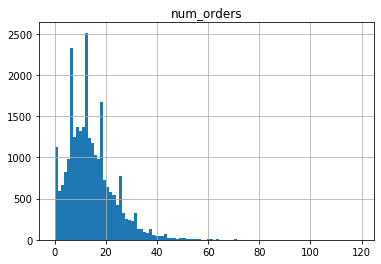

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/datasets/taxi.csv')
display(df.head())
df.describe()
df.hist(bins = 100)

Несмотря на то, что распределение смещено вправо, удалять выбросы не будем, чтобы не нарушать целостность временного ряда. Ресемплируем ряд,это поможет сгладить выбросы. 

In [2]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('datetime', drop = True).sort_index().resample('1H').sum()

## Анализ

Построим на одном графике фактическе значения ряда, значения скользящих средней и станд. отклонений.

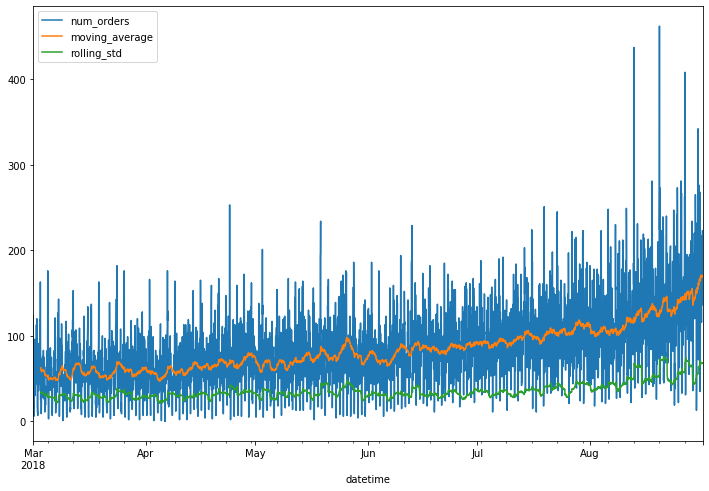

In [3]:
df['moving_average'] = df['num_orders'].shift().rolling(50).mean()
df['rolling_std'] = df['num_orders'].shift().rolling(50).std()
df.plot(figsize = (12,8))
plt.show()
df = df.drop('rolling_std', axis = 1)

Есть явный тренд на увеличение заказов со времененем. Станд. отклонение не сильно растет при росте среднего. Ряд хоть и не стационарный, но в целом прогнозируемый.

Попробуем найти сезонную компоненту, ибо в зависимости от времени суток спрос на такси циклично меняется.

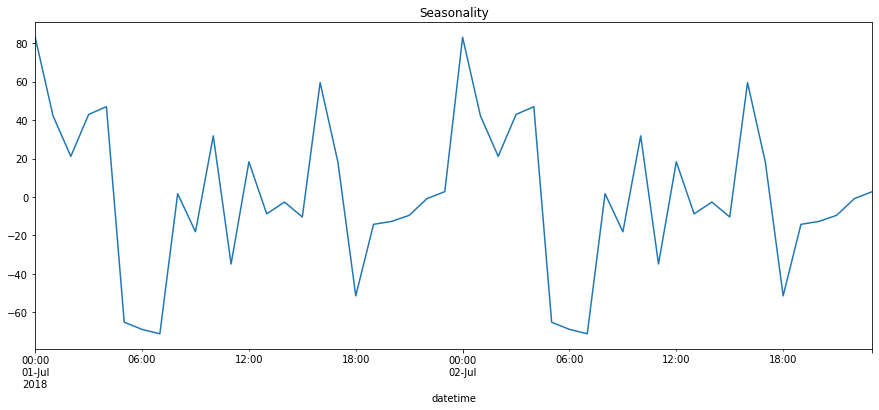

In [4]:
df_sample = df['2018-07-01':'2018-07-02']
decomposed = seasonal_decompose(df_sample['num_orders'])

plt.figure(figsize=(15, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Сезонность есть, и она выражена очень ярко: в полночь заказов наибольшее количество с падением до минимума по дню в 7:00. Также наблюдаются всплески заказов ближе к концу рабочего дня, около 17 часов.

## Обучение

Перед обучением сгенерируем фичи. Скользящее среднее уже умеется, для ряда, ресемпленного по часу достаточно будет календарных фичей часа, дня, дня недели. Добавим также отстающие значения, от 1 до 5.

Перед разделением на тестовую и тренировочную выборку удалим все пустые строки.

In [5]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)
df['lag_4'] = df['num_orders'].shift(4)
df['lag_5'] = df['num_orders'].shift(5)
train, test = train_test_split(df.dropna(), test_size = 0.1, shuffle = False)
target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop(columns='num_orders', axis = 1)
features_test = test.drop(columns='num_orders', axis = 1)
print('shape of train dataframes : features', features_train.shape, ' target', target_train.shape)
print('shape of test dataframes : features', features_test.shape, ' target', target_test.shape)

shape of train dataframes : features (3929, 9)  target (3929,)
shape of test dataframes : features (437, 9)  target (437,)


Начнем с модели линейной регрессии

In [6]:
model_regr = LinearRegression()
model_regr.fit(features_train, target_train)
prediction_train_regr = model_regr.predict(features_train)
print("RMSE обучающей выборки, линейная регрессия:", np.sqrt(mean_squared_error(prediction_train_regr, target_train)))

RMSE обучающей выборки, линейная регрессия: 30.559574827841548


Неплохой результат на обучающей выборке. Попробуем другие модели.

In [7]:
model_lgbm = LGBMRegressor(random_state=42, n_estimators=80, max_depth = 9, num_iterations = 600,  verbose= 10)
model_lgbm.fit(features_train, target_train,verbose = True)
prediction_train_lgbm = model_lgbm.predict(features_train)
print("RMSE обучающей выборки, LightGBM:", np.sqrt(mean_squared_error(prediction_train_lgbm, target_train)))

RMSE обучающей выборки, LightGBM: 6.4890787134223595


In [8]:
model_cb = CatBoostRegressor(iterations = 1000, random_seed = 42, max_depth = 9)
model_cb.fit(features_train, target_train,verbose=100)
prediction_train_cb = model_cb.predict(features_train)
print("RMSE обучающей выборки, Catboost:", model_cb.best_score_['learn']['RMSE'])

0:	learn: 38.1282582	total: 54.6ms	remaining: 54.6s
100:	learn: 22.2465366	total: 3.82s	remaining: 34s
200:	learn: 19.9492601	total: 7.56s	remaining: 30.1s
300:	learn: 18.2062911	total: 11.3s	remaining: 26.3s
400:	learn: 16.8516116	total: 15.4s	remaining: 22.9s
500:	learn: 15.4490312	total: 19.3s	remaining: 19.2s
600:	learn: 14.2071095	total: 23.1s	remaining: 15.4s
700:	learn: 13.1843210	total: 27.1s	remaining: 11.6s
800:	learn: 12.3343916	total: 31s	remaining: 7.69s
900:	learn: 11.5716223	total: 34.8s	remaining: 3.83s
999:	learn: 10.9001443	total: 38.7s	remaining: 0us
RMSE обучающей выборки, Catboost: 10.900144307901632


LGBM на тренировочной выборке показывает результаты получше, чем у catboost, при этом обучаясь гораздо быстрее при имеющихся гиперпараметрах. Посмотрим, что будет на тестовой выборке.

## Тестирование

Обучим данные на тестовой выборке, сравним результаты.

In [9]:
prediction_test_regr = model_regr.predict(features_test)
regr_rmse_test = np.sqrt(mean_squared_error(prediction_test_regr, target_test))
print("RMSE тестовой выборки, линейная регрессия:", regr_rmse_test)
prediction_test_lgbm = model_lgbm.predict(features_test)
lgbm_rmse_test = np.sqrt(mean_squared_error(prediction_test_lgbm, target_test))
print("RMSE тестовой выборки, LightGBM:", lgbm_rmse_test)
prediction_test_cb = model_cb.predict(features_test)
cb_rmse_test = np.sqrt(mean_squared_error(prediction_test_cb, target_test))
print("RMSE тестовой выборки, Catboost:", cb_rmse_test)

RMSE тестовой выборки, линейная регрессия: 50.08358860065255
RMSE тестовой выборки, LightGBM: 48.14908215144464
RMSE тестовой выборки, Catboost: 47.63060371594022


Несмотря на огромный разброс RMSE на тренировочной выборке, на тестовой они все показывают схожие результаты. Catboost, не будучи лучшей моделью по результатам обучения, единсвтенная преодолела таргет в RMSE 48. LightGBM немного не хватило до пороговых значений, и в следствие экспериментов выяснилось, что изменением количества итераций в контексте данного датафрейма результаты улучшить не удается. Линейная регрессия немного позади оппонентов с результатом 50.08.

Создадим датафрейм с таргетом в тестовой выборке и прогнозами моделей для визуального сравнения.

In [10]:
target_test_plt = pd.DataFrame(target_test.copy())
target_test_plt['regr_pred'] = prediction_test_regr.tolist()
target_test_plt['lgbm_pred'] = prediction_test_lgbm.tolist()
target_test_plt['cb_pred'] = prediction_test_cb.tolist()

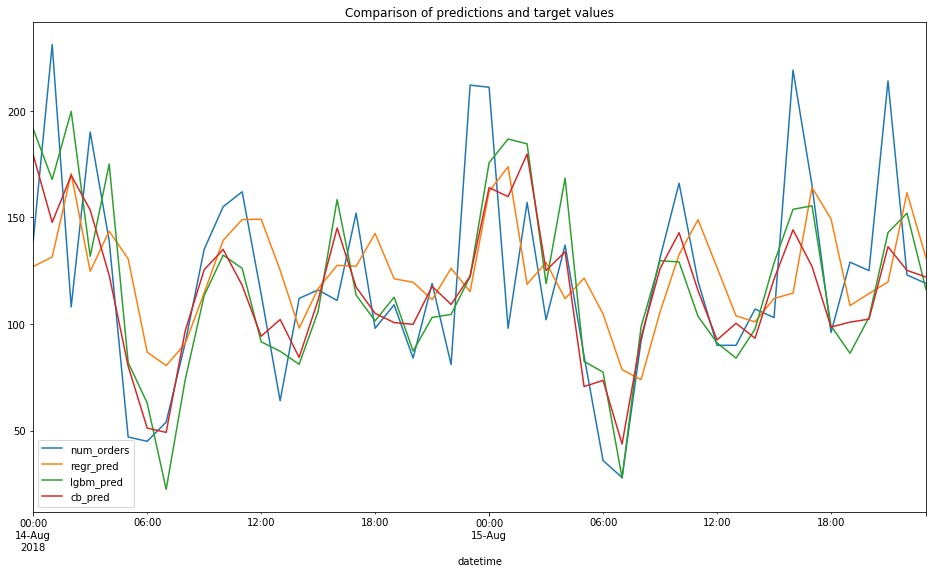

In [11]:
plt.figure(figsize=(16, 9))
target_test_plt['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Comparison of predictions and target values')
plt.show()


Исходя из анализа графика можно наблюдать довольно интересную вещь касательно CatBoost и LGBM. CatBoost сглаживает резкие изменения значений от часа к часу, и иногда это на руку, учитывая лаги при моделировании (особенно это видно в начале выведенного периода, когда факт бросает туда-сюда, catboost старается держаться посередине, а LGBM выбрасывается в противоположные стороны). В редких случаях стремление к резкому изменению значений у LGBM дает в результате относительно точные попадания в факт (15 августа, 7:00 и 17:00), но всё-таки этих случаев меньшинство, отсюда и хоть незначительная, но разница в RMSE в пользу Catboost.
